In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Kaggle
!ls

/content/gdrive/MyDrive/Kaggle
attn_plots				resultsHW4P2_40.csv
dev.npy					resultsHW4P2_41.csv
dev_transcripts.npy			sample.csv
hw4model_tf_lockdrop_model_epoch41.pth	test.npy
hw4model_tf_lockdrop_optim_epoch41.pth	train.npy
kaggle.json				train_transcripts.npy
resultsHW4P2_39.csv


In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
# !kaggle competitions download -c 11-785-fall-20-homework-4-part-2

In [ ]:
# !unzip \*.zip  && rm *.zip

In [ ]:
!ls

attn_plots			   resultsHW4P2_30.csv	resultsHW4P24.csv
dev.npy				   resultsHW4P2_32.csv	resultsHW4P2_50.csv
dev_transcripts.npy		   resultsHW4P2_34.csv	resultsHW4P25.csv
hw4model_tf_reg_model_epoch35.pth  resultsHW4P2_35.csv	sample.csv
hw4model_tf_reg_model_epoch36.pth  resultsHW4P2_36.csv	test.npy
hw4model_tf_reg_model_epoch37.pth  resultsHW4P2_39.csv	train.npy
hw4model_tf_reg_model_epoch38.pth  resultsHW4P2_3.csv	train_transcripts.npy
hw4model_tf_reg_model_epoch39.pth  resultsHW4P23.csv
kaggle.json			   resultsHW4P2_40.csv


In [ ]:
!pip install python-Levenshtein

     |████████████████████████████████| 51kB 5.6MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144795 sha256=9840618a2e494a0cbae3ee03a06224bc64b1f0a3ce65a43d70202bace10a27cc
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.utils as utils
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import time
import pdb

import Levenshtein as Lev
# import warnings

%matplotlib inline

In [ ]:
cuda = True if torch.cuda.is_available() else False
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(DEVICE)
print(cuda)
print(torch.cuda.get_device_name(0))

LETTER_LIST = ['<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ','<eos>','<sos>']

def plot_attn_flow(attn_mask, path):
    plt.imsave(path, attn_mask, cmap='hot')
    return plt               

True
Tesla V100-SXM2-16GB


In [ ]:
#DATALOADER START
'''
Loading all the numpy files containing the utterance information and text information
''' 
def load_data():
    speech_train = np.load('./train.npy', allow_pickle=True, encoding='bytes')
    speech_valid = np.load('./dev.npy', allow_pickle=True, encoding='bytes')
    speech_test = np.load('./test.npy', allow_pickle=True, encoding='bytes')

    transcript_train = np.load('./train_transcripts.npy', allow_pickle=True, encoding='bytes')
    transcript_valid = np.load('./dev_transcripts.npy', allow_pickle=True, encoding='bytes')

    return speech_train, speech_valid, speech_test, transcript_train, transcript_valid

In [ ]:
'''
Transforms alphabetical input to numerical input, replace each letter by its corresponding 
index from letter_list
'''
def transform_letter_to_index(transcript, letter_list):
    '''
    :param transcript :(N, ) Transcripts are the text input
    :param letter_list: Letter list defined above
    :return letter_to_index_list: Returns a list for all the transcript sentence to index
    '''    
    letter2index, _ = create_dictionaries(letter_list)
    final_list = []
    for text in transcript:
        text_list = [letter2index['<sos>']]
        text = [word.decode('utf-8') for word in text]
        for word in text:
            text_list.extend(letter2index[char] for char in word)
            text_list.append(letter2index[' '])
        text_list.append(letter2index['<eos>'])
        final_list.append(text_list)
    return final_list

def transform_index_to_letter(indices, letter_list):
    '''
    :param indices :(N, maxlen) indices are the index input (ndarray)
    :param letter_list: Letter list defined above
    :return index_to_letter_list: Returns a list for all the indices to text
    '''    
    _, index2letter = create_dictionaries(letter_list)
    
    #convert indices to symbols
    final_list = []
    for index_list in indices:
        sentence = ''
        for num, index in enumerate(index_list):
            if index < 0:
                continue
            elif num == 0 and index2letter[index] == '<sos>':
                continue
            elif index2letter[index] == '<eos>' or index2letter[index] == '<pad>':
                break
            elif index >= 0:
                sentence += index2letter[index]

        final_list.append(sentence)
    return final_list

In [ ]:
'''
Optional, create dictionaries for letter2index and index2letter transformations
'''
def create_dictionaries(letter_list):
    letter2index = dict()
    index2letter = dict()
    letter2index = {letter_list[i]:i for i in range(len(letter_list))}
    index2letter = {value:key for (key, value) in letter2index.items()}
    return letter2index, index2letter

letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
class Speech2TextDataset(Dataset):
    '''
    Dataset class for the speech to text data, this may need some tweaking in the
    getitem method as your implementation in the collate function may be different from
    ours. 
    '''
    def __init__(self, speech, text=None, isTrain=True):
        self.speech = speech
        self.isTrain = isTrain
        if (text is not None):
            self.text = text

    def __len__(self):
        return self.speech.shape[0]

    def __getitem__(self, index):
        if (self.isTrain == True):
            return torch.tensor(self.speech[index].astype(np.float32)), torch.tensor(self.text[index])
        else:
            return torch.tensor(self.speech[index].astype(np.float32))

In [ ]:
def collate_train(batch_data):
    ### Return the padded speech and text data, and the length of utterance and transcript ###
    sequences = [x[0] for x in batch_data]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    input_lengths = torch.LongTensor([len(x) for x in sequences])
    labels = [x[1][1:] for x in batch_data]
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
    label_lengths = torch.LongTensor([x.shape[0] for x in labels])
    return sequences_padded, labels_padded, input_lengths, label_lengths


def collate_test(batch_data):
    ### Return padded speech and length of utterance ###
    sequences = [x for x in batch_data]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    input_lengths = torch.LongTensor([len(x) for x in sequences])
    return sequences_padded, input_lengths

#DATALOADER END

In [ ]:
#MODEL START
class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, lens):
        '''
        :param query :(batch_size, hidden_size) Query is the output of LSTMCell from Decoder
        :param keys: (batch_size, max_len, encoder_size) Key Projection from Encoder
        :param values: (batch_size, max_len, encoder_size) Value Projection from Encoder
        :return context: (batch_size, encoder_size) Attended Context
        :return attention_mask: (batch_size, max_len) Attention mask that can be plotted 
        '''

        # return context, masked_attention
        query = query.unsqueeze(2) # shape mismatch
        energy = torch.bmm(key, query)# key(b, Tmax, key_size(128)), query(b, key_size, 1) -> (b, Tmax, 1)        
        energy = energy.squeeze(2) #(b, Tmax, 1) -> (b, Tmax) 

        maxlen = torch.max(lens) # Tmax
        row_vector = torch.arange(0, maxlen, 1)
        matrix = torch.unsqueeze(lens, dim=-1)
        mask = (row_vector >= matrix).to(DEVICE)

        energy.masked_fill_(mask, -1e9)
        masked_attention = F.softmax(energy, dim = 1) #(b, Tmax)
        masked_attention = masked_attention.unsqueeze(1) #(b, 1, Tmax)

        context = torch.bmm(masked_attention, value) #(b, 1, Tmax) * (b, Tmax, enc_size) = (b, 1, enc_size)
        context = context.squeeze(1) #(b, enc_size)

        masked_attention = masked_attention.squeeze(1) #(b, Tmax)

        return context, masked_attention

In [ ]:
def weight_drop(module, weights_names_ls, dropout_p):

    original_module_forward = module.forward

    def forward(*args, **kwargs):
        for name_param in weights_names_ls:
            param = module._parameters.get(name_param)
            param_with_dropout = nn.Parameter(torch.nn.functional.dropout(param, p=dropout_p),
                                                requires_grad=param.requires_grad)
            module._parameters.__setitem__(name_param, param_with_droput)

            return original_module_forward(*args, **kwargs)

    setattr(module, 'forward', forward)
    return module

class LockedDropout(nn.Module):

    def __init__(self, p=0.3):
        self.p = p
        super().__init__()

    def forward(self, x):
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(x.size(0), 1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'

class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    The length of utterance (speech input) can be hundereds to thousands of frames long.
    The Paper reports that a direct LSTM implementation as Encoder resulted in slow convergence,
    and inferior results even after extensive training.
    The major reason is inability of AttendAndSpell operation to extract relevant information
    from a large number of input steps.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True).to(DEVICE)
        self.lockdrop = LockedDropout()
        # weights = ['weight_hh_l' + str(i) for i in range(1)]
        # self.blstm = weight_drop(self.blstm, weights, 0.3)

    def forward(self, x):
        '''
        :param x :(N, T) input to the pBLSTM
        :return output: (N, T, H) encoded sequence from pyramidal Bi-LSTM         
        '''        
        x, x_lengths = utils.rnn.pad_packed_sequence(x, batch_first=True) #padding after previous lstm
        if x.shape[1]%2 != 0:
            x = x[:,:-1,:]
        x = x.contiguous().view(x.shape[0], x.shape[1]//2, x.shape[2] * 2)
        x = utils.rnn.pack_padded_sequence(x, lengths = x_lengths//2, batch_first=True, enforce_sorted=False)
        x, hidden = self.blstm(x) 
        x, x_lengths = utils.rnn.pad_packed_sequence(x, batch_first=True) #padding after previous lstm
        x = self.lockdrop(x)
        x = utils.rnn.pack_padded_sequence(x, lengths = x_lengths, batch_first=True, enforce_sorted=False)
        return x

In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key and value.
    Key and value are nothing but simple projections of the output from pBLSTM network.
    '''
    def __init__(self, input_dim, hidden_dim, value_size=256,key_size=256):
        super(Encoder, self).__init__()
        #input = 40, hidden = 256, out = 512
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True).to(DEVICE)
        self.lockdrop = LockedDropout()
        
        ### Add code to define the blocks of pBLSTMs! ###
        self.pBLSTM1 = pBLSTM(4 * hidden_dim, hidden_dim).to(DEVICE) #input=256*2, hidden=256, out=512
        self.pBLSTM2 = pBLSTM(4 * hidden_dim, hidden_dim).to(DEVICE) #in=512, out=512
        self.pBLSTM3 = pBLSTM(4 * hidden_dim, hidden_dim).to(DEVICE) #in=512, out=512

        self.key_network = nn.Linear(hidden_dim*2, value_size).to(DEVICE)
        self.value_network = nn.Linear(hidden_dim*2, key_size).to(DEVICE)

    def forward(self, x, lens):
        rnn_inp = utils.rnn.pack_padded_sequence(x, lengths=lens, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(rnn_inp)
        outputs, out_lengths = utils.rnn.pad_packed_sequence(outputs, batch_first=True) #padding after previous lstm
        outputs = self.lockdrop(outputs)
        outputs = utils.rnn.pack_padded_sequence(outputs, lengths = out_lengths, batch_first=True, enforce_sorted=False)

        ### Use the outputs and pass it through the pBLSTM blocks! ###
        outputs = self.pBLSTM1(outputs)
        outputs = self.pBLSTM2(outputs)
        outputs = self.pBLSTM3(outputs)

        linear_input, lengths = utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        keys = self.key_network(linear_input)
        value = self.value_network(linear_input)

        return keys, value, lengths

In [ ]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step, 
    thus we use LSTMCell instead of LSLTM here.
    The output from the second LSTMCell can be used as query here for attention module.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, hidden_dim, value_size=256, key_size=256, isAttended=False):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=0).to(DEVICE) # weight tying (v, 512)
        # self.emb_drop = nn.Dropout(0.1).to(DEVICE)

        self.lstm1 = nn.LSTMCell(input_size= hidden_dim + value_size, hidden_size=2*hidden_dim).to(DEVICE)
        self.lstm2 = nn.LSTMCell(input_size=2*hidden_dim, hidden_size=key_size).to(DEVICE) # use output as query in attention

        self.isAttended = isAttended
        if (isAttended == True):
            self.attention = Attention()
        
        self.another_linear = nn.Linear(256, 256).to(DEVICE)
        self.elu1 = nn.ELU().to(DEVICE)
        self.bn1 = nn.BatchNorm1d(256).to(DEVICE)
        
        self.yet_another_linear = nn.Linear(256, 256).to(DEVICE)
        self.elu2 = nn.ELU().to(DEVICE)
        self.bn2 = nn.BatchNorm1d(256).to(DEVICE)

        self.character_prob = nn.Linear(key_size + value_size, vocab_size) # weight tying (256, v)

        self.character_prob.weight = self.embedding.weight

    def forward(self, key, values, lens, text=None, isTrain=True, tf = 0.9):
        '''
        :param key :(T, N, key_size) Output of the Encoder Key projection layer
        :param values: (T, N, value_size) Output of the Encoder Value projection layer
        :param text: (N, text_len) Batch input of text with text_length
        :param isTrain: Train or eval mode
        :return predictions: Returns the character perdiction probability 
        '''
        batch_size = key.shape[0]
        
        if isTrain or text != None:
          text = torch.cat([torch.Tensor(np.array([34]*batch_size)).unsqueeze(1).long(),text],dim = 1)          

        if isTrain or text != None:
            max_len = text.shape[1]
            embeddings = self.embedding(text) #35, 256
        else:             
            max_len = 600
        
        if isTrain or text != None:
            predictions = []
            hidden_states = [None, None]
            prediction = (torch.ones(batch_size, 1)*34).to(DEVICE)
            all_attentions = []
            context = values[:,0,:]
        
            for i in range(max_len - 1):

                if (isTrain):
                    # teacher forcing
                    p = np.random.random()
                    if p < tf:
                        char_embed = embeddings[:,i,:]    
                    else: 
                        char_embed = self.embedding(prediction.argmax(dim=-1))  
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1))

                inp = torch.cat([char_embed, context], dim=1)
                hidden_states[0] = self.lstm1(inp, hidden_states[0]) #(b,256)

                inp_2 = hidden_states[0][0]
                hidden_states[1] = self.lstm2(inp_2, hidden_states[1]) #(b,512)

                output = hidden_states[1][0] #(b,128)

                context, attention = self.attention(output,key,values,lens) #batch_size x encoder_size
                all_attentions.append(attention[0].detach().cpu()) #Tdecode, Tencode

                out = self.another_linear(output)
                out = self.elu(out)
                out = self.bn(out)

                cont = self.yet_another_linear(context)
                cont = self.elu2(cont)
                cont = self.bn2(cont)

                prediction = self.character_prob(torch.cat([out, cont], dim=1)) # pred = b x vocab
                predictions.append(prediction.unsqueeze(1)) # b x 1 x vocab
        # all_attentions = torch.stack(all_attentions, dim=1)

            return torch.cat(predictions, dim=1) , all_attentions
        
        else: #random search   
            n_seq = 1000 #number of random sequences generated for each input sequence.      
            all_attentions = []            
            prediction = (torch.ones(n_seq, 1)*34).to(DEVICE) #n_seq <sos>
            context = values[:,0,:] #1, 128
            context = context.repeat(n_seq,1) # 1, 128 -> n_seq, 128
            hidden_states = [None, None]
            all_attentions = []
            pred_sum = torch.zeros(size = (n_seq,)).to(DEVICE)
            sequences = None
            for i in range(max_len):                 
                if i == 0:
                    char_embed = self.embedding(prediction.argmax(dim=-1))#(n_seq, 256) for test
                else:
                    indices = torch.randint(0, 34, size = (n_seq,1)).to(DEVICE) #generate random indices for each sequence
                    if sequences == None:
                        sequences = indices #start sequences with the first n_seq indices
                    else:
                        sequences = torch.cat([sequences, indices], dim = 1) #(n_seq, max_len - 2) not including <sos> and last elem
                    char_embed = self.embedding(indices.squeeze(1)) # n_seq, 256
                    probs = F.log_softmax(prediction, dim = -1) #n_seq, 35 prediction converted  
                    probs = probs.gather(1, indices) #n_seq, 1                 
                    pred_sum = pred_sum + probs.squeeze(1) #check shape = n_seq,                                               
                
                inp = torch.cat([char_embed, context], dim=1) # context should be (1, 128). should context be broadcast along (1000, 128)?
                del char_embed
                del context
                hidden_states[0] = self.lstm1(inp, hidden_states[0]) #(n_seq,256)
                del inp

                inp_2 = hidden_states[0][0]
                hidden_states[1] = self.lstm2(inp_2, hidden_states[1]) #(n_seq,512)
                del inp_2
                output = hidden_states[1][0] #(n_seq,512)

                big_key = key.repeat(n_seq,1,1) #(n_seq, t_enc, 256)
                big_val = values.repeat(n_seq,1,1) #(n_seq, t_enc, 256)
                context, _ = self.attention(output, big_key, big_val, lens) #check dimension here
                del big_key
                del big_val
                
                fc_output = self.relu1(self.bn1(self.fc1(output)))
                context_out = self.relu2(self.bn2(self.fc2(context)))                
                prediction = self.character_prob(torch.cat([fc_output, context_out], dim=1)) #logits(n_seq, vocab)
                del fc_output
                del context_out
                torch.cuda.empty_cache()
            # pdb.set_trace()
            best_prob = torch.argmax(pred_sum)            
            best_pred = sequences[best_prob.item()]
            return best_pred, all_attentions

In [ ]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, hidden_dim, value_size=256, key_size=256, isAttended=False):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim).to(DEVICE)
        self.decoder = Decoder(vocab_size, hidden_dim, isAttended = isAttended).to(DEVICE)

    def forward(self, speech_input, speech_len, text_input=None, isTrain=True, tf = 0.9):
        key, value, lens = self.encoder(speech_input, speech_len)
        if (isTrain == True):
            predictions, all_attentions = self.decoder(key, value, lens, text_input, tf = tf)          
        else:
            predictions, all_attentions = self.decoder(key, value, lens, text=text_input, isTrain=False)
        return predictions, all_attentions
#MODEL END

In [ ]:
#TRAIN/EVAL
def train(model, train_loader, criterion, optimizer, epoch, tf = 0.9):
    model.train()
    model.to(DEVICE)
    start = time.time()
    epoch_loss = 0    

    for batch, (inp, text, inp_lens, text_lens) in enumerate(train_loader):
        if (batch+1) % 20 == 0:
            print("BATCHES: {}".format(batch+1))        
        inp, text = inp.to(DEVICE), text.to(DEVICE)        
        optimizer.zero_grad()
        predictions, all_attentions = model(inp, inp_lens, text, isTrain = True, tf = tf)
        
        if (batch+1)%200 == 0:            
            all_attentions = torch.stack(all_attentions) #decoder_maxlen, encoder_maxlen
            att_plt = plot_attn_flow(all_attentions, 'attn_plots/batch{}.png'.format(batch+1))
            att_plt.show()
            plt.matshow(all_attentions)

        # making mask for predictions and targets
        maxlen = torch.max(text_lens)
        row_vector = torch.arange(0, maxlen, 1)
        matrix = torch.unsqueeze(text_lens, dim=-1)
        mask = row_vector < matrix
        mask = mask.type(torch.float).to(DEVICE)        

        masked_text = text[:,1:] * mask #removing <sos> from targets and masking
        masked_pred = predictions * mask.unsqueeze(2)

        masked_pred = masked_pred.reshape(masked_pred.shape[0] * masked_pred.shape[1], masked_pred.shape[2]).type(torch.float).contiguous()
        masked_text = masked_text.reshape(-1).long()
        
        loss = criterion(masked_pred, masked_text).sum()/torch.sum(mask)
        
        loss.backward()
        epoch_loss += loss.item()
        ##########
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

    epoch_loss = epoch_loss/(batch + 1)
    
    end = time.time()
    return epoch_loss

def evaluate(model, eval_loader, epoch, greedy = True, tf = 0.9):
    model.eval()
    model.to(DEVICE)
    error = 0
    total = 0
    for batch, (inp, text, inp_lens, text_lens) in enumerate(eval_loader):
        inp, text = inp.to(DEVICE), text.to(DEVICE)        
        text_lens = text_lens
        predictions, all_attentions = model(inp, inp_lens, text, isTrain=False, tf = tf) 
        
        #making mask for targets and predictions
        maxlen = torch.max(text_lens)
        row_vector = torch.arange(0, maxlen, 1)
        matrix = torch.unsqueeze(text_lens, dim=-1)
        mask = (row_vector >= matrix).to(DEVICE)
        
        #applying masks
        masked_text = text#removing <sos>
        del text
        masked_text.masked_fill_(mask, -1e9)    
        if greedy:
            predictions = torch.argmax(predictions, dim = 2) #get argmax at each time step (b,seqlen, vocab) -> (b,seqlen)
        else:
            pass #beam or random
        predictions.masked_fill_(mask, -1e9)
        
        #converting predictions and targets to text
        predictions = transform_index_to_letter(predictions.detach().cpu().numpy(), LETTER_LIST)           
        text = transform_index_to_letter(masked_text.detach().cpu().numpy(), LETTER_LIST)
        if (batch == 5):
            print("pred: {}".format(predictions[0]))
            print("target: {}".format(text[0])) 
        
        #computing Lev distance
        for pred, t in zip(predictions, text):
            error += Lev.distance( pred, t)
        total += len(predictions)
    print("EPOCH: {} | Mean Lev Distance: {}".format(epoch+1, error / total))
    return error/total

In [ ]:
model = Seq2Seq(input_dim=40, vocab_size=len(LETTER_LIST), hidden_dim=512, value_size=256, key_size=256, isAttended=True)
model = model.to(DEVICE)
# model.load_state_dict(torch.load("hw4model_tf_lockdrop_model_epoch40.pth"))
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer.load_state_dict(torch.load("hw4model_tf_lockdrop_optim_epoch40.pth"))
criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=2, verbose=True, threshold=1e-2)
nepochs = 45
# batch_size = 128 if DEVICE == 'cuda' else 5
train_batch_size = 64
val_batch_size = 64 #1 for beam else 64

In [ ]:
speech_train, speech_valid, speech_test, transcript_train, transcript_valid = load_data()
# speech_test = load_data()
print("DATA LOADED")
character_text_train = transform_letter_to_index(transcript_train, LETTER_LIST)
character_text_valid = transform_letter_to_index(transcript_valid, LETTER_LIST)
print("DATA TRANSFORMED TO INDICES")

train_dataset = Speech2TextDataset(speech_train, character_text_train)
val_dataset = Speech2TextDataset(speech_valid, character_text_valid)
test_dataset = Speech2TextDataset(speech_test, None, False)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_train)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, collate_fn=collate_train)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_test)
print("TRAIN DATA LOADER LOADED")

DATA LOADED
DATA TRANSFORMED TO INDICES
TRAIN DATA LOADER LOADED


446
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200
BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


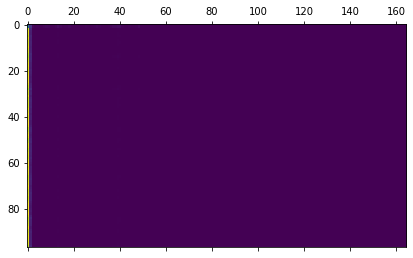

BATCHES: 420
BATCHES: 440
EPOCH: 1 | LOSS: 1.2288472169985152
pred: ere 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 1 | Mean Lev Distance: 101.68257491675915
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


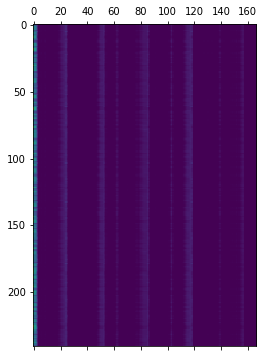

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


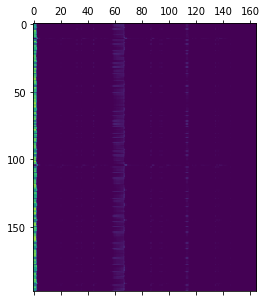

BATCHES: 420
BATCHES: 440
EPOCH: 2 | LOSS: 0.9912472033179929
pred: were the sale 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 2 | Mean Lev Distance: 97.86052534221236
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


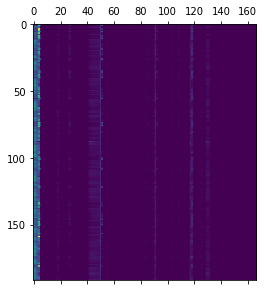

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


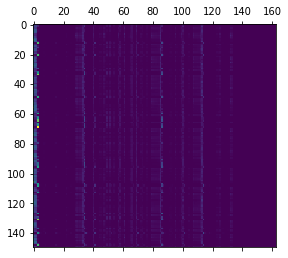

BATCHES: 420
BATCHES: 440
EPOCH: 3 | LOSS: 0.9293785100560552
pred: the second 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 3 | Mean Lev Distance: 98.47724750277469
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


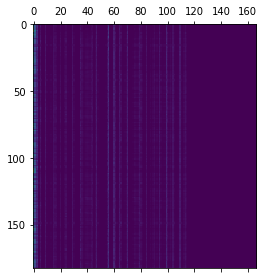

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


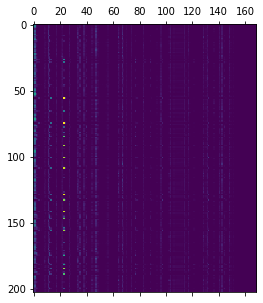

BATCHES: 420
BATCHES: 440
EPOCH: 4 | LOSS: 0.8934220623542375
pred: the same time 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 4 | Mean Lev Distance: 97.12467628560859
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


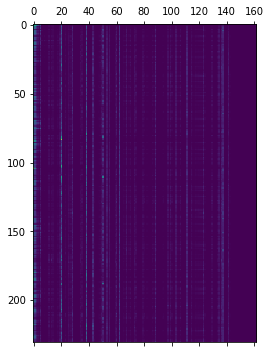

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


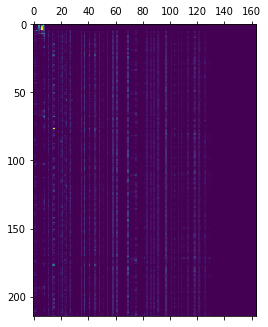

BATCHES: 420
BATCHES: 440
EPOCH: 5 | LOSS: 0.8683245208765894
pred: the moment 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 5 | Mean Lev Distance: 94.69071402145764
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


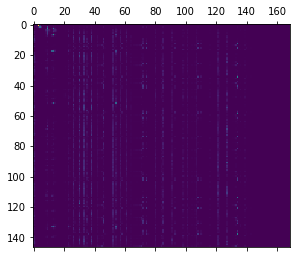

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


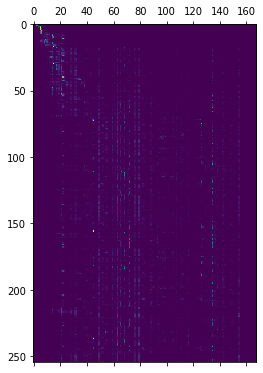

BATCHES: 420
BATCHES: 440
EPOCH: 6 | LOSS: 0.8088530156377185
pred: but she must te make to make a said say 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 6 | Mean Lev Distance: 75.82241953385127
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


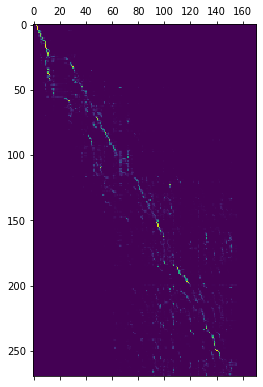

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


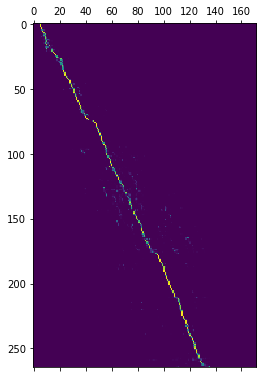

BATCHES: 420
BATCHES: 440
EPOCH: 7 | LOSS: 0.49965414939439884
pred: but she never heard him still he consented say ah i shall nistepwart surgeon 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 7 | Mean Lev Distance: 54.91675915649279
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


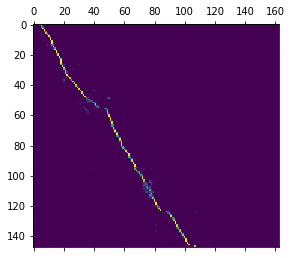

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


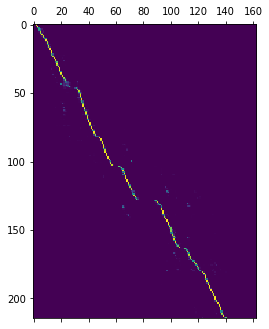

BATCHES: 420
BATCHES: 440
EPOCH: 8 | LOSS: 0.335328827424167
pred: but she left him near peace to he consented saying i wish some mister port surren 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 8 | Mean Lev Distance: 42.991120976692564
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


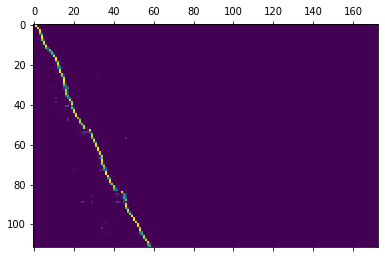

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


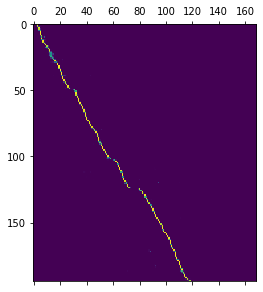

BATCHES: 420
BATCHES: 440
EPOCH: 9 | LOSS: 0.28655666761066884
pred: but she left him no puest to he consented saying ah shall mister forechildren 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 9 | Mean Lev Distance: 38.3559008509064
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


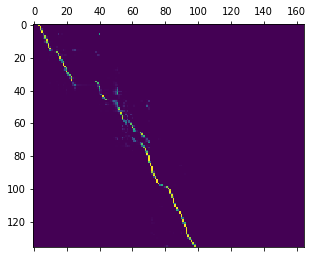

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


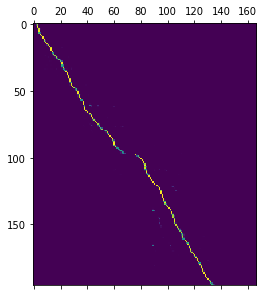

BATCHES: 420
BATCHES: 440
EPOCH: 10 | LOSS: 0.239112629183472
pred: but she left him no puest of he concerned her saying ah said she'll mist the fort children
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 10 | Mean Lev Distance: 37.360340362560116
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


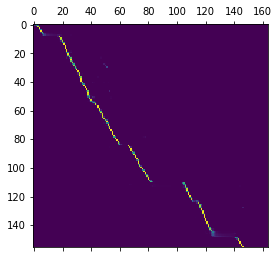

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


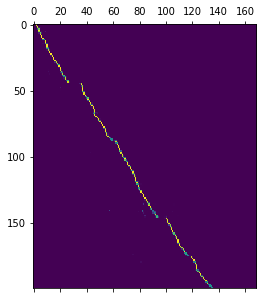

BATCHES: 420
BATCHES: 440
EPOCH: 11 | LOSS: 0.22480893519293568
pred: but she never knew he still he concerned her saying ah it shall mister fortrildren 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 11 | Mean Lev Distance: 32.712171661117274
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


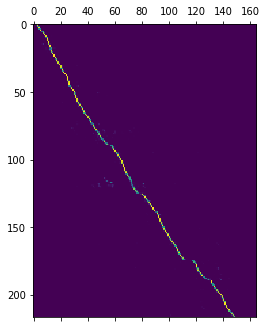

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


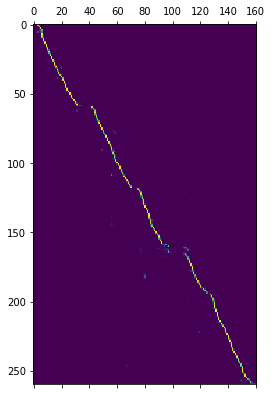

BATCHES: 420
BATCHES: 440
EPOCH: 12 | LOSS: 0.1992524708934429
pred: but she not to know a keys to leave consenter saying ah that shalm miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 12 | Mean Lev Distance: 30.17610062893082
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


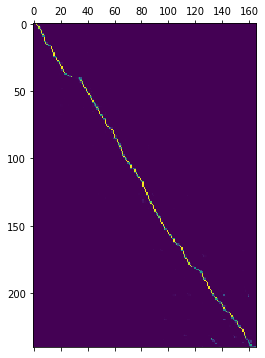

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


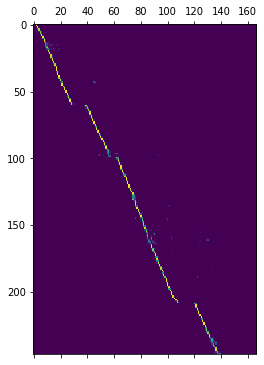

BATCHES: 420
BATCHES: 440
EPOCH: 13 | LOSS: 0.17825622054760767
pred: but she never to near piece till he concented saying ah that shalm miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 13 | Mean Lev Distance: 28.87939326674066
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


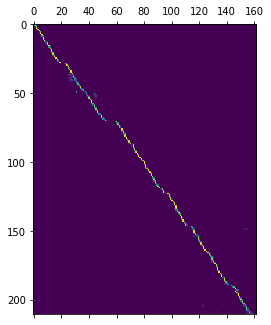

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


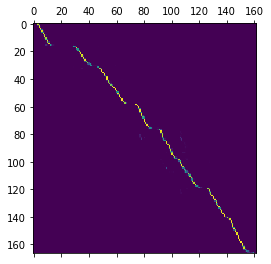

BATCHES: 420
BATCHES: 440
EPOCH: 14 | LOSS: 0.16327908919130205
pred: but she net him near piece till he consented saying ah they shall miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 14 | Mean Lev Distance: 27.972623011468738
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


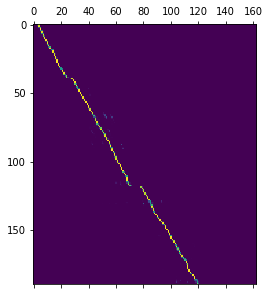

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


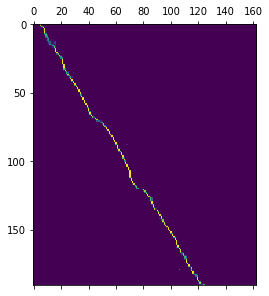

BATCHES: 420
BATCHES: 440
EPOCH: 15 | LOSS: 0.1507198142363886
pred: but she never to nere piece to heconcentr saying ah that shall miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 15 | Mean Lev Distance: 26.71106178320385
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


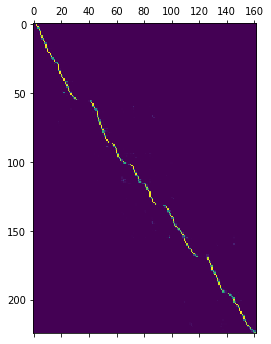

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


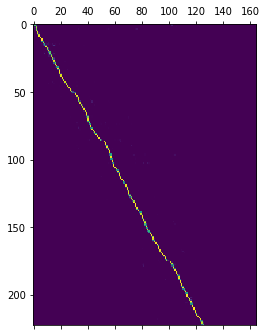

BATCHES: 420
BATCHES: 440
EPOCH: 16 | LOSS: 0.15874987130675616
pred: but she never ceased to be consented saying ah they shall mist the porch our ring 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 16 | Mean Lev Distance: 27.55086940436552
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


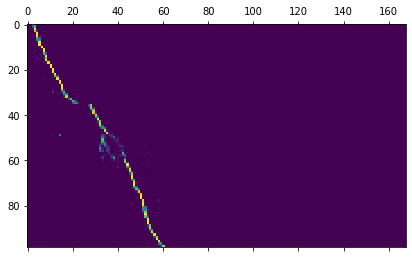

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


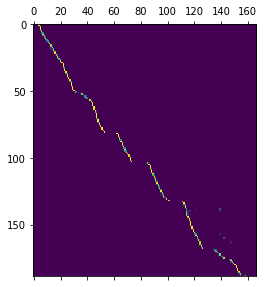

BATCHES: 420
BATCHES: 440
EPOCH: 17 | LOSS: 0.190357116422712
pred: but she not ten no kies till he consented saying oh i shall miss the porch oldaran 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 17 | Mean Lev Distance: 25.209027007029228
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


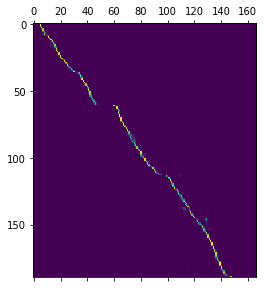

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


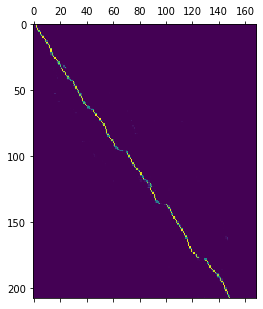

BATCHES: 420
BATCHES: 440
EPOCH: 18 | LOSS: 0.1366644510038765
pred: but she not him nertheasteally consented saying ah leist shall miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 18 | Mean Lev Distance: 25.106178320384757
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


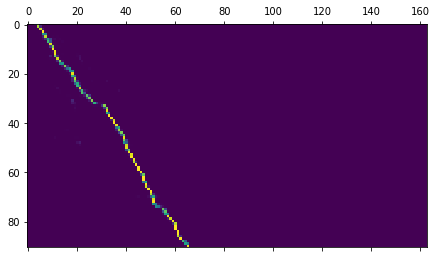

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


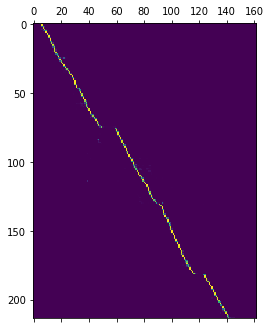

BATCHES: 420
BATCHES: 440
EPOCH: 19 | LOSS: 0.12450499508546607
pred: but she never come still he consented saying ah this shall miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 19 | Mean Lev Distance: 25.74583795782464
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


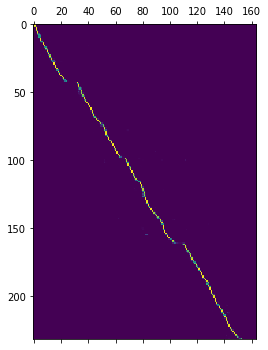

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


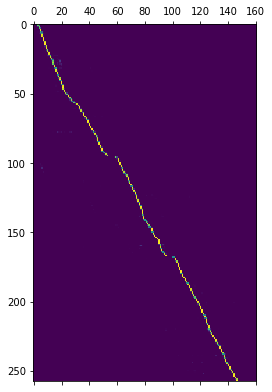

BATCHES: 420
BATCHES: 440
EPOCH: 20 | LOSS: 0.11843588335163925
pred: but she never to near peace till he consented saying ah we shall miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 20 | Mean Lev Distance: 24.352201257861637
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


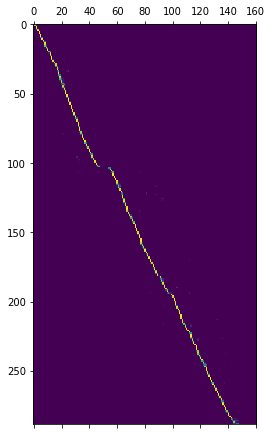

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


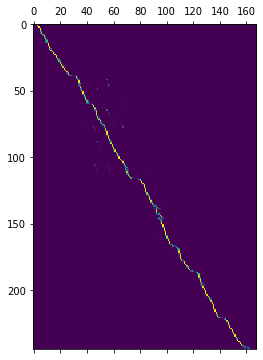

BATCHES: 420
BATCHES: 440
EPOCH: 21 | LOSS: 0.13424830147035988
pred: but you nove to new peace till he consented saying oh that shall miss the porch ulder 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 21 | Mean Lev Distance: 24.517943026267112
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


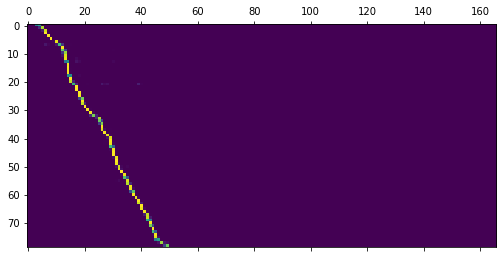

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


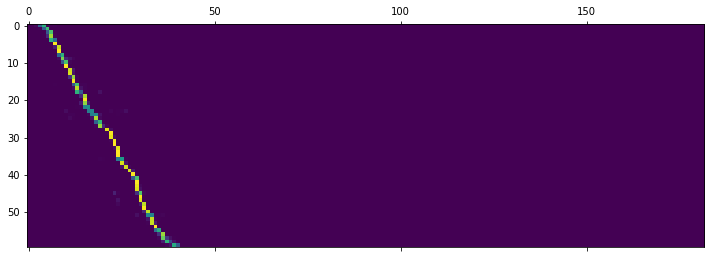

BATCHES: 420
BATCHES: 440
EPOCH: 22 | LOSS: 0.12719488195707446
pred: but she never case till he consented saying oh that shalm mist the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 22 | Mean Lev Distance: 22.758046614872363
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


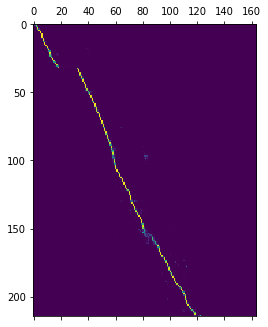

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


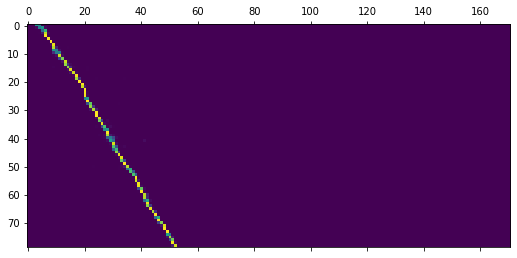

BATCHES: 420
BATCHES: 440
EPOCH: 23 | LOSS: 0.11795481426365707
pred: but she neved him nere peace till he consented saying ah just when miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 23 | Mean Lev Distance: 23.631890492045876
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


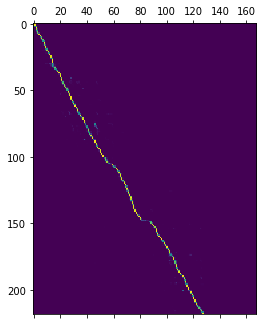

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


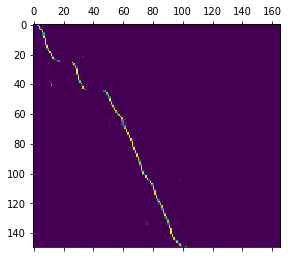

BATCHES: 420
BATCHES: 440
EPOCH: 24 | LOSS: 0.10976322598321021
pred: but you neve to near peace till he consented saying oh if i shall miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 24 | Mean Lev Distance: 22.685904550499444
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


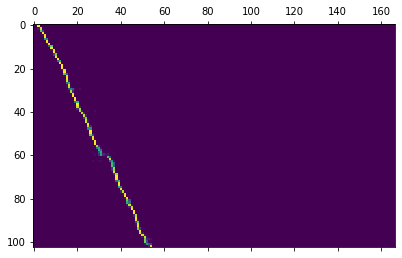

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


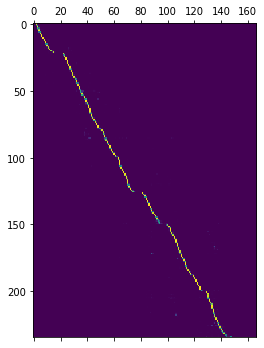

BATCHES: 420
BATCHES: 440
EPOCH: 25 | LOSS: 0.10378230526842878
pred: but you neve to  near peace till he consented saying i have a shall miss the portchaldren 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 25 | Mean Lev Distance: 22.615242323344432
Epoch    18: reducing learning rate of group 0 to 3.0000e-04.
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


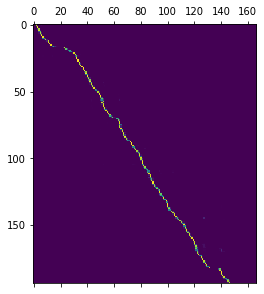

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


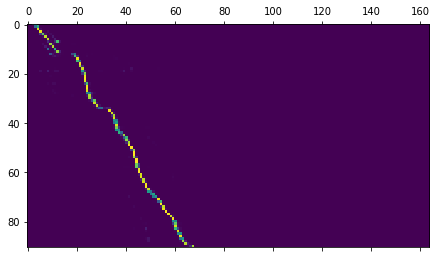

BATCHES: 420
BATCHES: 440
EPOCH: 26 | LOSS: 0.08264375651764763
pred: but she not to mere peace till he consented saying ah don't you show mister portchaldren 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 26 | Mean Lev Distance: 20.940436551979282
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


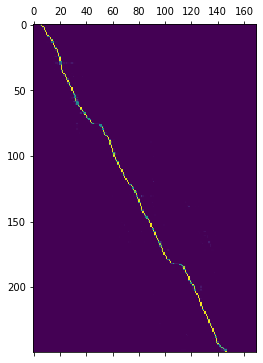

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


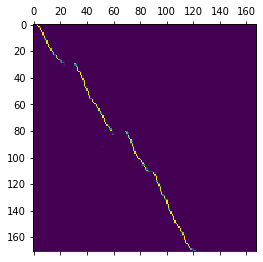

BATCHES: 420
BATCHES: 440
EPOCH: 27 | LOSS: 0.06953556975976234
pred: but you never came no piece till he consented saying oh that shalmaness the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 27 | Mean Lev Distance: 20.26896041435442
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


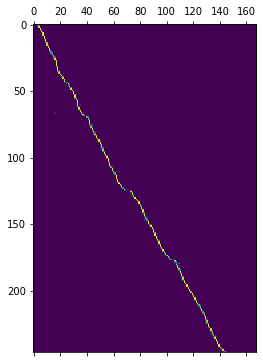

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


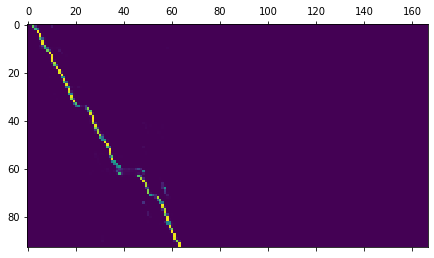

BATCHES: 420
BATCHES: 440
EPOCH: 28 | LOSS: 0.06350803969954161
pred: but she neved him no peace till he consented saying oh that shalmaness the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 28 | Mean Lev Distance: 20.137994820569737
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


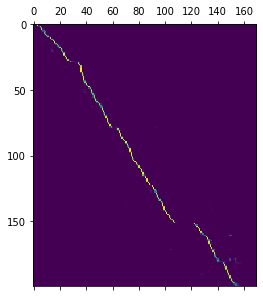

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


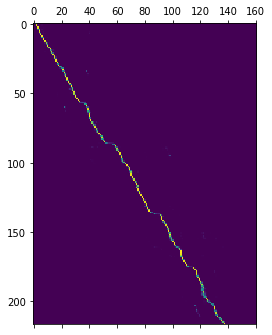

BATCHES: 420
BATCHES: 440
EPOCH: 29 | LOSS: 0.059355983786251516
pred: but she neved him no peace till he consented saying ah that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 29 | Mean Lev Distance: 19.995560488346282
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


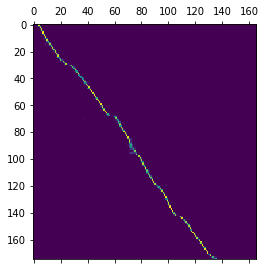

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


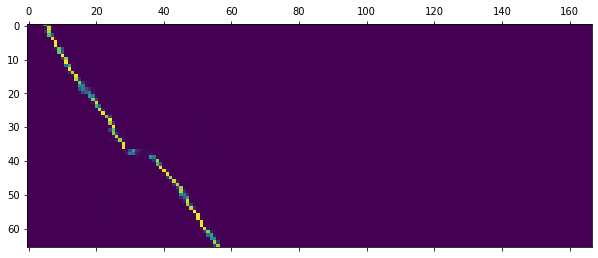

BATCHES: 420
BATCHES: 440
EPOCH: 30 | LOSS: 0.05476720349220016
pred: but she neved him no peace till he consented saying oh that shalm miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 30 | Mean Lev Distance: 19.706252312245653
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


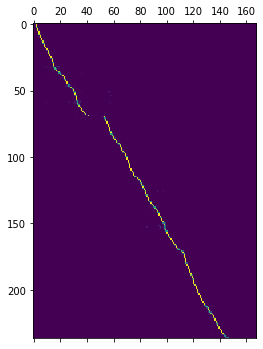

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


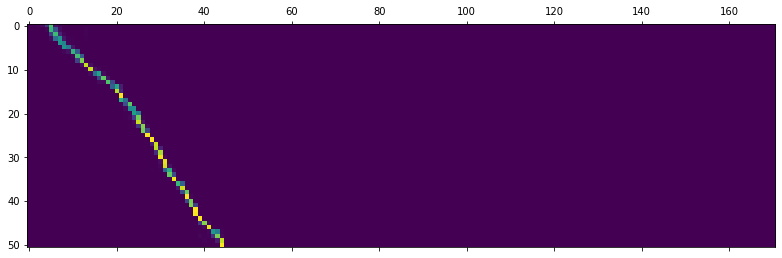

BATCHES: 420
BATCHES: 440
EPOCH: 31 | LOSS: 0.05100368320808282
pred: but she neved him no peace till he consented saying ah that's 't that the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 31 | Mean Lev Distance: 19.99038105808361
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


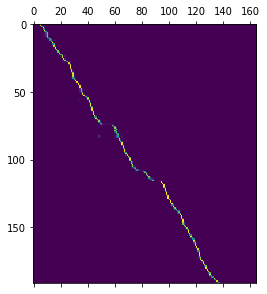

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


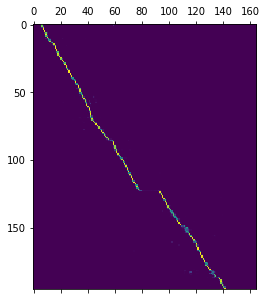

BATCHES: 420
BATCHES: 440
EPOCH: 32 | LOSS: 0.04856096386007397
pred: but she never to near peace till he consented saying oh that's on this the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 32 | Mean Lev Distance: 20.260081391046985
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


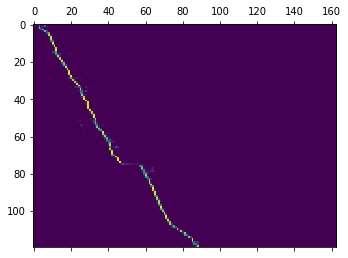

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


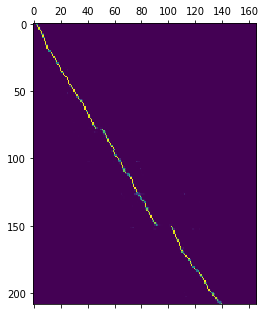

BATCHES: 420
BATCHES: 440
EPOCH: 33 | LOSS: 0.04623357876884697
pred: but she neved him no peace till he consented saying oh that's she   mist the poor children
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 33 | Mean Lev Distance: 20.3496115427303
Epoch    26: reducing learning rate of group 0 to 9.0000e-05.
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


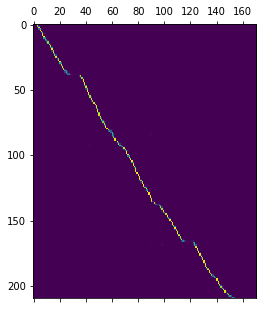

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


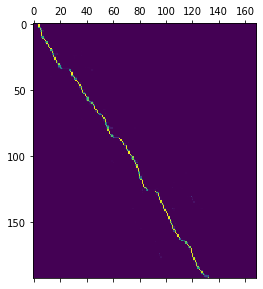

BATCHES: 420
BATCHES: 440
EPOCH: 34 | LOSS: 0.038557229041552066
pred: but she never drew peace till he consented saying oh that's she on miss the poor children 
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 34 | Mean Lev Distance: 19.651868294487606
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


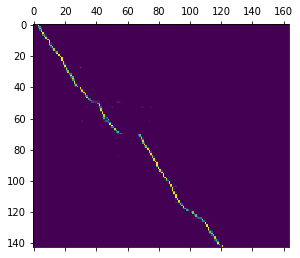

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


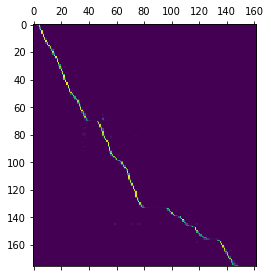

BATCHES: 420
BATCHES: 440
EPOCH: 35 | LOSS: 0.03475332826860416
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 35 | Mean Lev Distance: 19.682574916759158
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


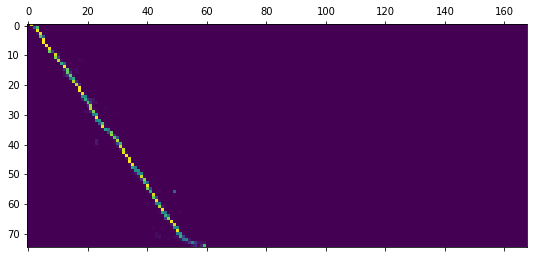

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


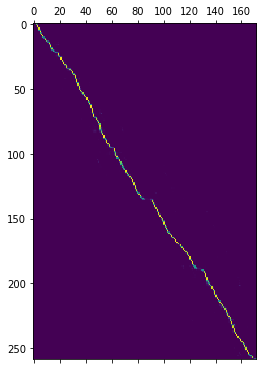

BATCHES: 420
BATCHES: 440
EPOCH: 36 | LOSS: 0.033168957121837296
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 36 | Mean Lev Distance: 20.20421753607103
Epoch    29: reducing learning rate of group 0 to 2.7000e-05.
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


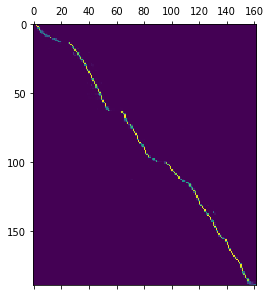

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


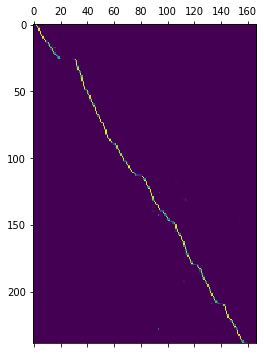

BATCHES: 420
BATCHES: 440
EPOCH: 37 | LOSS: 0.03057659170151826
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 37 | Mean Lev Distance: 19.620421753607104
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


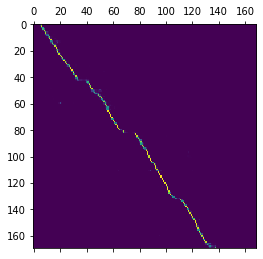

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


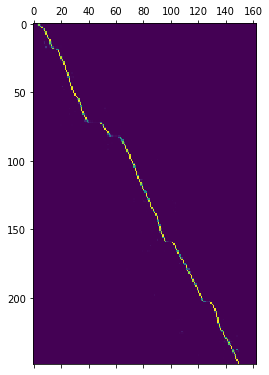

BATCHES: 420
BATCHES: 440
EPOCH: 38 | LOSS: 0.029793833305165506
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 38 | Mean Lev Distance: 19.381428042915278
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


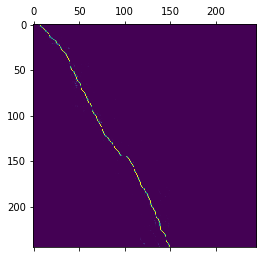

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


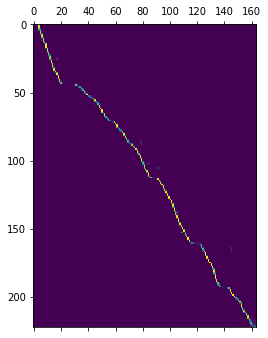

BATCHES: 420
BATCHES: 440
EPOCH: 39 | LOSS: 0.028723555080375465
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 39 | Mean Lev Distance: 19.626711061783205
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


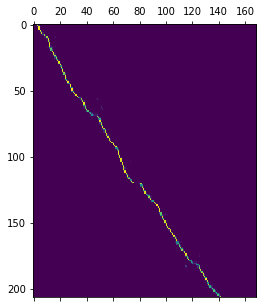

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


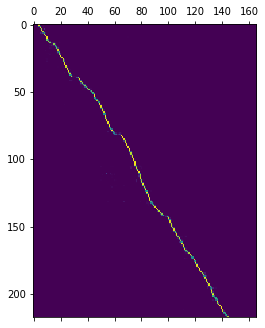

BATCHES: 420
BATCHES: 440
EPOCH: 40 | LOSS: 0.02808906492305243
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 40 | Mean Lev Distance: 19.557898631150575
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


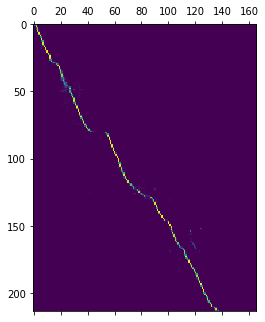

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


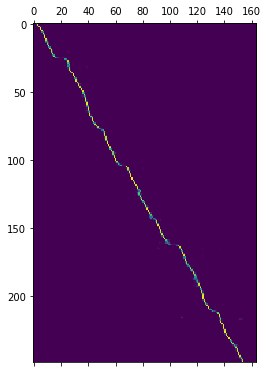

BATCHES: 420
BATCHES: 440
EPOCH: 41 | LOSS: 0.028770942489445343
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 41 | Mean Lev Distance: 19.369219385867556
Epoch    34: reducing learning rate of group 0 to 8.1000e-06.
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


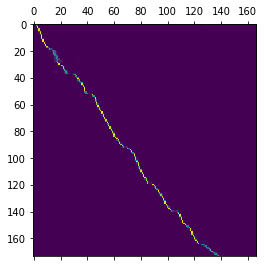

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


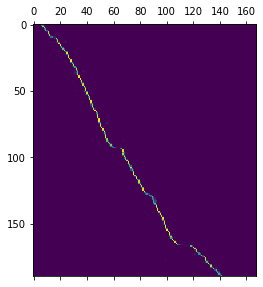

BATCHES: 420
BATCHES: 440
EPOCH: 42 | LOSS: 0.02717875480033758
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 42 | Mean Lev Distance: 19.510173880873104
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


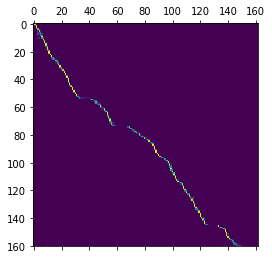

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


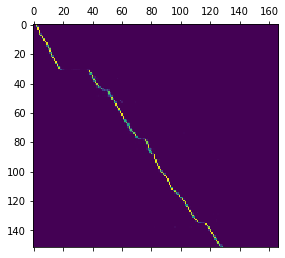

BATCHES: 420
BATCHES: 440
EPOCH: 43 | LOSS: 0.027301954560716858
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 43 | Mean Lev Distance: 19.603033666296707
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


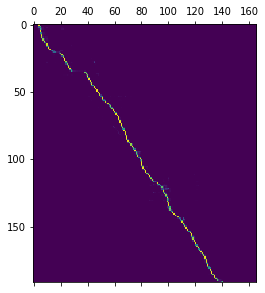

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


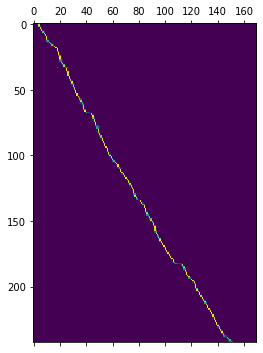

BATCHES: 420
BATCHES: 440
EPOCH: 44 | LOSS: 0.026726369065286866
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 44 | Mean Lev Distance: 19.318165001849795
Epoch    37: reducing learning rate of group 0 to 2.4300e-06.
BATCHES: 20
BATCHES: 40
BATCHES: 60
BATCHES: 80
BATCHES: 100
BATCHES: 120
BATCHES: 140
BATCHES: 160
BATCHES: 180
BATCHES: 200


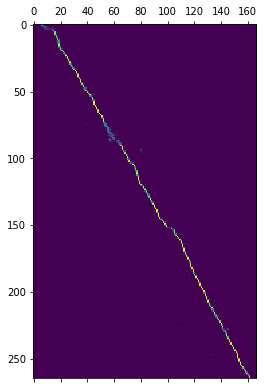

BATCHES: 220
BATCHES: 240
BATCHES: 260
BATCHES: 280
BATCHES: 300
BATCHES: 320
BATCHES: 340
BATCHES: 360
BATCHES: 380
BATCHES: 400


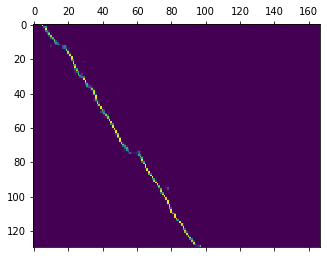

BATCHES: 420
BATCHES: 440
EPOCH: 45 | LOSS: 0.027072765711995652
pred: but she neved him no peace till he consented saying oh that's she on miss the poor childre
target: but she left him no peace till he consented saying ah but i shall miss the poor children 
EPOCH: 45 | Mean Lev Distance: 19.588605253422124


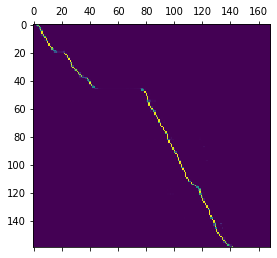

In [ ]:
import os
epoch = 0
tf = 0.9
print(len(train_loader))
for epoch in range(epoch, nepochs):  
    if epoch < 10:
        tf = 0.9
    elif epoch >= 10 and epoch < 20:
        tf = 0.8
    elif epoch >= 20 and epoch < 25:
        tf = 0.75
    else:
        tf = 0.7
    epoch_loss = train(model, train_loader, criterion, optimizer, epoch, tf = tf)
    print("EPOCH: {} | LOSS: {}".format(epoch+1, epoch_loss))
    if epoch >= 25:    
        torch.save(model.state_dict(),'./hw4model_tf_model_epoch{}.pth'.format(epoch+1))
        torch.save(optimizer.state_dict(), './hw4model_tf_optim_epoch{}.pth'.format(epoch+1))
    elif epoch%5 == 0:
        torch.save(model.state_dict(),'./hw4model_tf_model_epoch{}.pth'.format(epoch+1))
        torch.save(optimizer.state_dict(), './hw4model_tf_optim_epoch{}.pth'.format(epoch+1))
    if (epoch+1) % 1 == 0:
        mean_lev = evaluate(model, val_loader, epoch, greedy = True, tf = tf)
    if epoch >= 7:
        scheduler.step(mean_lev)

In [ ]:
debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
#TBD
import pandas as pd
model = Seq2Seq(input_dim=40, vocab_size=len(LETTER_LIST), hidden_dim=512, isAttended=True)
model.load_state_dict(torch.load("hw4model_tf_model_epoch36.pth"))
#load model
def test(model, test_loader, epoch, test = False, greedy = True):
    prediction_list = []
    model.eval()
    model.to(DEVICE)
    print(len(test_loader))
    with torch.no_grad():
        for batch, (inp, inp_lens) in enumerate(test_loader):
            print(batch)
            inp = inp.to(DEVICE)            
            predictions, _ = model(inp, inp_lens, isTrain = False, tf = 0.9)
            if greedy:
                predictions = torch.argmax(predictions, dim = 2) #get argmax at each time step (b,seqlen, vocab) -> (b,seqlen)
            else:
                pass #beam or random
            
            #converting predictions to text            
            if len(predictions.shape) == 1:
                predictions = predictions.unsqueeze(0)
            prediction_list.extend(transform_index_to_letter(predictions.detach().cpu().numpy(), LETTER_LIST)) 
            print(prediction_list[batch])   
    
    id = np.arange(0, len(prediction_list))
    return pd.DataFrame(list(zip(id, prediction_list)), columns =['id', 'label'])

prediction_list = test(model, test_loader, 0, test = True, greedy = True)
#TRAIN/TEST END

41
0
it has been my privileged to try the soil of many a lands to observe the customs and study to habits of more nations at one and i get to find the place at me to people whereing with whom the curate of man and woman his head war precious than among the balight morements in a mountain valleys of the west 
1
we believe it a little resolrection and in actual hero after anward feature states shall be recognized every santified of authorized relationship and chisting huronnora of paradise child brother insistered husband in life 
2
moreover had the people been inclined to rebellion well get her opportunity could they have wished 
3
what to let it in sayings call so less trom rerds his character is take up to church and ussienevery general practice but of so estial marriage again poeriany of wise was of incident never of the central 
4
and so the story of mormon is and wrenzon its finalie has not yet been written the corn crest presents continuously loose dataities of its plaguess new de

In [ ]:
debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
prediction_list.to_csv('resultsHW4P2_36.csv', index=False)

In [ ]:
!scp kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions submit -c 11-785-fall-20-homework-4-part-2 -f resultsHW4P2_36.csv -m "Let's see"

100% 293k/293k [00:03<00:00, 79.5kB/s]
Successfully submitted to 11-785-Fall-20-Homework 4 Part 2